### **Description**: Learn how to download, analyze, and preprocess data with pandas. We then build a simple Linear Model using the keras.Dense layer and predict new values. Then extend this model to a deep neural network and learn about the importance of activation functions.


In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

np.set_printoptions(precision=3, suppress=True)

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [37]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [39]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [40]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1
dataset['Europe'] = (origin == 2) * 1
dataset['Japan'] = (origin == 3) * 1

In [41]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [44]:
# Split the data into train and test
train_dataset = dataset.sample(frac=.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [45]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [46]:
def plot(feature, x=None, y=None):
  plt.figure(figsize=(10, 8))
  plt.scatter(train_features[feature], train_labels, label='Data')
  if x is not None and y is not None:
    plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel(feature)
  plt.ylabel('MPG')
  plt.legend()

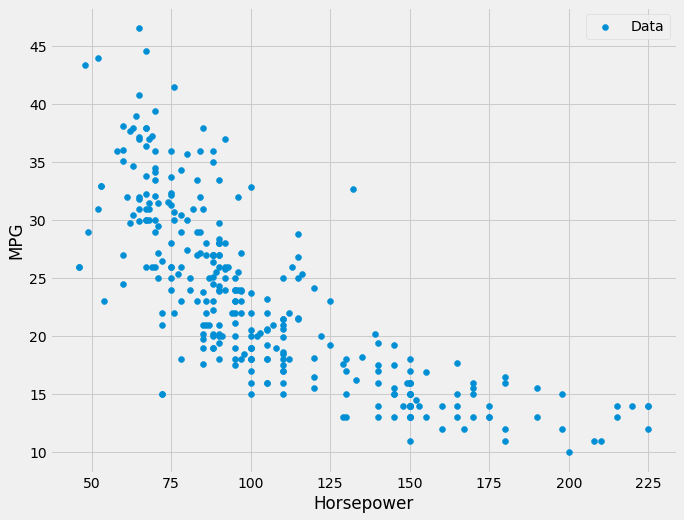

In [47]:
plot('Horsepower')

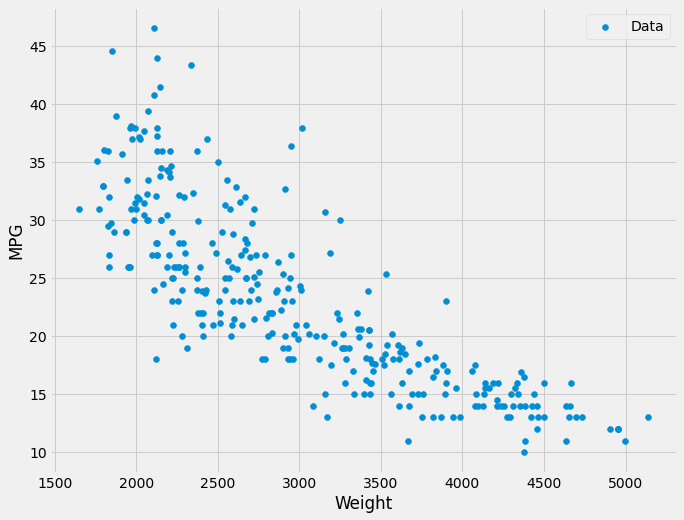

In [48]:
plot('Weight')

In [52]:
# Normalize
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization 
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
    0.197]


In [53]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input - mean) / stddev
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [55]:
# Regression
#  1. Normalize the input horsepower
#  2. Apply a linear transformation ( y = m*x+b ) to produce 1 output using layers.Dense
feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization 
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(np.array(single_feature))

(314,) (314, 9)


In [56]:
# Sequential model
single_feature_model = keras.models.Sequential(
    [
     single_feature_normalizer,
     layers.Dense(units=1) # Linear Model
    ]
)

In [57]:
single_feature_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [58]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(lr=.1)

single_feature_model.compile(optimizer=optim, loss=loss)

In [60]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose = 1,
    # Calculate validation results on 20% of the training data
    validation_split = .2
)

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 22.8665 - val_loss: 22.9327
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0631 - val_loss: 22.1328
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 21.2621 - val_loss: 21.3328
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 20.4650 - val_loss: 20.5330
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 19.6634 - val_loss: 19.7331
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 18.8618 - val_loss: 18.9330
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 18.0622 - val_loss: 18.1329
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 17.2623 - val_loss: 17.3328
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 16.4661 - val_loss: 16.5330
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6633 - val_loss: 15.7328
Epoch 11

In [63]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

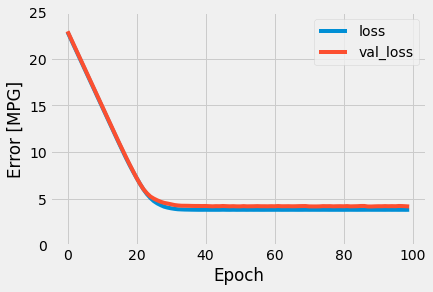

In [67]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 25])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [69]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1
)

3/3 [==============================] - 0s 3ms/step - loss: 3.6466


3.646599054336548

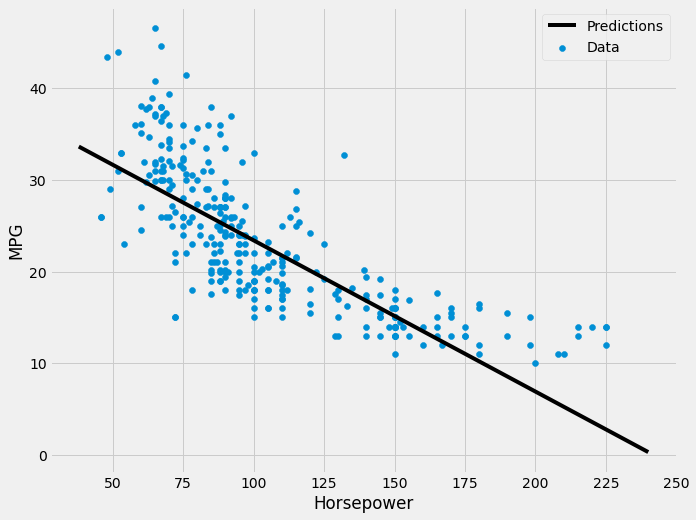

In [71]:
# predict and plot
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)

plot(feature, x, y)

In [72]:
 # DNN
 dnn_model = keras.Sequential(
     [
      single_feature_normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
     ]
 )

In [73]:
dnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [74]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=.2,
    verbose=1, epochs=100
)

Epoch 1/100
8/8 [==============================] - 0s 15ms/step - loss: 23.1200 - val_loss: 23.5108
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.8975 - val_loss: 23.2739
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 22.6637 - val_loss: 22.9921
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 22.3628 - val_loss: 22.6264
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 21.9743 - val_loss: 22.1576
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 21.4731 - val_loss: 21.5394
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 20.7986 - val_loss: 20.7504
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 19.9660 - val_loss: 19.7526
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 18.9097 - val_loss: 18.5546
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 17.6967 - val_loss: 17.1895
Epoch 11

In [75]:
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 2.8914


2.891390562057495

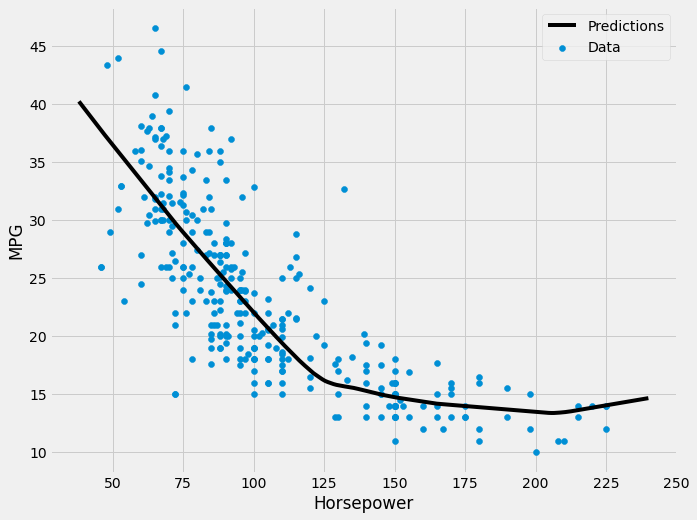

In [76]:
# predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x, y)

In [77]:
# multiple_inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss
)

In [79]:
linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2
)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 22.9770 - val_loss: 22.8513
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.1000 - val_loss: 22.1700
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2605 - val_loss: 21.4690
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 20.4430 - val_loss: 20.7227
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 19.6225 - val_loss: 20.0000
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 18.8026 - val_loss: 19.2673
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 17.9920 - val_loss: 18.5341
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 17.1566 - val_loss: 17.8129
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 16.3418 - val_loss: 17.0969
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.5317 - val_loss: 16.3928
Epoch 11

In [81]:
linear_model.evaluate(
    test_features, test_labels, verbose=1
)

3/3 [==============================] - 0s 2ms/step - loss: 2.5078


2.5077764987945557